In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Load the dataset
data = pd.read_csv(r'/content/updata.csv', index_col=0)

# Preview the dataset
data.head()


,from,to,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
#,,,,,,,,,,,,
1,2023-02-01 00:00:00,2023-02-01 00:15:00,95.0,35.0,NaN,90.1,56.2,0.31,NaN,17.7,28.1,0.4
2,2023-02-01 00:15:00,2023-02-01 00:30:00,95.0,35.0,NaN,88.0,55.1,0.33,NaN,18.3,27.1,0.4
3,2023-02-01 00:30:00,2023-02-01 00:45:00,95.0,35.0,NaN,87.7,55.2,0.38,NaN,19.7,24.9,0.4
4,2023-02-01 00:45:00,2023-02-01 01:00:00,122.0,34.0,NaN,88.9,55.7,0.38,NaN,21.3,21.9,0.4
5,2023-02-01 01:00:00,2023-02-01 01:15:00,122.0,34.0,NaN,90.0,55.8,0.38,NaN,22.3,16.7,0.4


In [41]:
# Step 2: Convert 'from' column to datetime and extract date
data['from'] = pd.to_datetime(data['from'], format='%Y-%m-%d %H:%M:%S')
# deleting to column as we need only one timestamp column for to be index and we choose it to be from column
data = data.drop('to', axis=1)
data.head()


,from,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
#,,,,,,,,,,,
1,2023-02-01 00:00:00,95.0,35.0,NaN,90.1,56.2,0.31,NaN,17.7,28.1,0.4
2,2023-02-01 00:15:00,95.0,35.0,NaN,88.0,55.1,0.33,NaN,18.3,27.1,0.4
3,2023-02-01 00:30:00,95.0,35.0,NaN,87.7,55.2,0.38,NaN,19.7,24.9,0.4
4,2023-02-01 00:45:00,122.0,34.0,NaN,88.9,55.7,0.38,NaN,21.3,21.9,0.4
5,2023-02-01 01:00:00,122.0,34.0,NaN,90.0,55.8,0.38,NaN,22.3,16.7,0.4


In [42]:
# Simplify column names
data.columns = ['from', 'PM10', 'PM2.5', 'NO','NO2','NOX','CO','SO2','NH3','Ozone','Benzene']

In [43]:
# Impute missing values in each column with its column-specific average
# data = data.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)
# Apply interpolation to numeric columns, leave others unchanged
def fill_with_avg_and_interpolate(col):
    if col.dtype in ['float64', 'int64']:  # Check if column is numeric
        col = col.interpolate(method='spline', order=2)  # Perform spline interpolation
        # Replace NaN at the start and end with the column mean
        col.fillna(col.mean(), inplace=True)
    return col

# Apply the function to all columns in the DataFrame
data = data.apply(fill_with_avg_and_interpolate)



In [44]:
# Extract the date for grouping
data['date'] = data['from'].dt.date

In [45]:
# Step 2: Group by date and calculate daily averages
daily_avg = data.groupby('date').mean()

In [46]:
daily_avg.head()

,from,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
date,,,,,,,,,,,
2023-02-01,2023-02-01 11:52:30,114.739583,35.145833,14.428266,78.831797,48.530026,0.449284,35.620127,22.146269,32.386064,0.232292
2023-02-02,2023-02-02 11:52:30,177.458333,52.020833,14.428266,79.055371,53.576805,1.279423,35.620127,22.409227,25.875865,0.120801
2023-02-03,2023-02-03 11:52:30,171.270833,52.916667,14.428266,82.263043,56.639537,1.197265,35.620127,23.193211,27.709662,0.165625
2023-02-04,2023-02-04 11:52:30,191.527249,70.690232,14.428266,76.674860,53.341595,1.124689,35.620127,25.273148,27.588217,0.185188
2023-02-05,2023-02-05 11:52:30,225.061703,77.524592,14.428266,72.368352,63.216050,0.883730,35.620127,25.979271,24.179688,0.212001


In [47]:
# Step 3: Define updated AQI breakpoints
breakpoints = {
    "PM10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 200, 101, 250),
             (201, 300, 251, 350), (301, 400, 351, 430), (401, 500, 430, float('inf'))],
    "PM2.5": [(0, 50, 0, 30), (51, 100, 31, 60), (101, 200, 61, 90),
              (201, 300, 91, 120), (301, 400, 121, 250), (401, 500, 250, float('inf'))],
    "NO2": [(0, 50, 0, 40), (51, 100, 41, 80), (101, 200, 81, 180),
            (201, 300, 181, 280), (301, 400, 281, 400), (401, 500, 400, float('inf'))],
    "O3": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 200, 101, 168),
           (201, 300, 169, 208), (301, 400, 209, 748), (401, 500, 748, float('inf'))],
    "CO": [(0, 50, 0, 1.0), (51, 100, 1.1, 2.0), (101, 200, 2.1, 10.0),
           (201, 300, 10.1, 17.0), (301, 400, 17.1, 34.0), (401, 500, 34.1, float('inf'))],
    "SO2": [(0, 50, 0, 40), (51, 100, 41, 80), (101, 200, 81, 380),
            (201, 300, 381, 800), (301, 400, 801, 1600), (401, 500, 1600, float('inf'))],
    "NH3": [(0, 50, 0, 200), (51, 100, 201, 400), (101, 200, 401, 800),
            (201, 300, 801, 1200), (301, 400, 1201, 1800), (401, 500, 1801, float('inf'))]
}


In [48]:
# Step 4: Define the function to calculate AQI sub-index
def calculate_aqi_subindex(C, breakpoints):
    for bp in breakpoints:
        i_low, i_high, c_low, c_high = bp
        if c_low <= C <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (C - c_low) + i_low
    return None

In [49]:
# Step 5: Calculate daily AQI for each row in the daily_avg DataFrame
def calculate_daily_aqi(row):
    subindexes = {}
    for pollutant, bps in breakpoints.items():
        if pollutant in row and not np.isnan(row[pollutant]):
            subindex = calculate_aqi_subindex(row[pollutant], bps)
            if subindex is not None:
                subindexes[pollutant] = subindex
    if subindexes:
        return max(subindexes.values())  # Return the highest AQI value
    return None

In [50]:
daily_avg['AQI'] = daily_avg.apply(calculate_daily_aqi, axis=1)

In [51]:
# Step 6: Save the results to a new CSV file
output_file = 'daily_aqi_results.csv'
daily_avg.to_csv(output_file)

print(f"Daily AQI calculations without Pb saved to {output_file}")

Daily AQI calculations without Pb saved to daily_aqi_results_no_pb.csv


In [52]:
daily_avg.head()

,from,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene,AQI
date,,,,,,,,,,,,
2023-02-01,2023-02-01 11:52:30,114.739583,35.145833,14.428266,78.831797,48.530026,0.449284,35.620127,22.146269,32.386064,0.232292,110.128985
2023-02-02,2023-02-02 11:52:30,177.458333,52.020833,14.428266,79.055371,53.576805,1.279423,35.620127,22.409227,25.875865,0.120801,151.801174
2023-02-03,2023-02-03 11:52:30,171.270833,52.916667,14.428266,82.263043,56.639537,1.197265,35.620127,23.193211,27.709662,0.165625,147.690017
2023-02-04,2023-02-04 11:52:30,191.527249,70.690232,14.428266,76.674860,53.341595,1.124689,35.620127,25.273148,27.588217,0.185188,161.148977
2023-02-05,2023-02-05 11:52:30,225.061703,77.524592,14.428266,72.368352,63.216050,0.883730,35.620127,25.979271,24.179688,0.212001,183.430259


# 2. EDA

### 2.1AQI Time-Series Analysis

In [53]:
# Step 1: Prepare data for time-series visualization
daily_avg['date'] = daily_avg.index  # Reset the index to use date for plotting

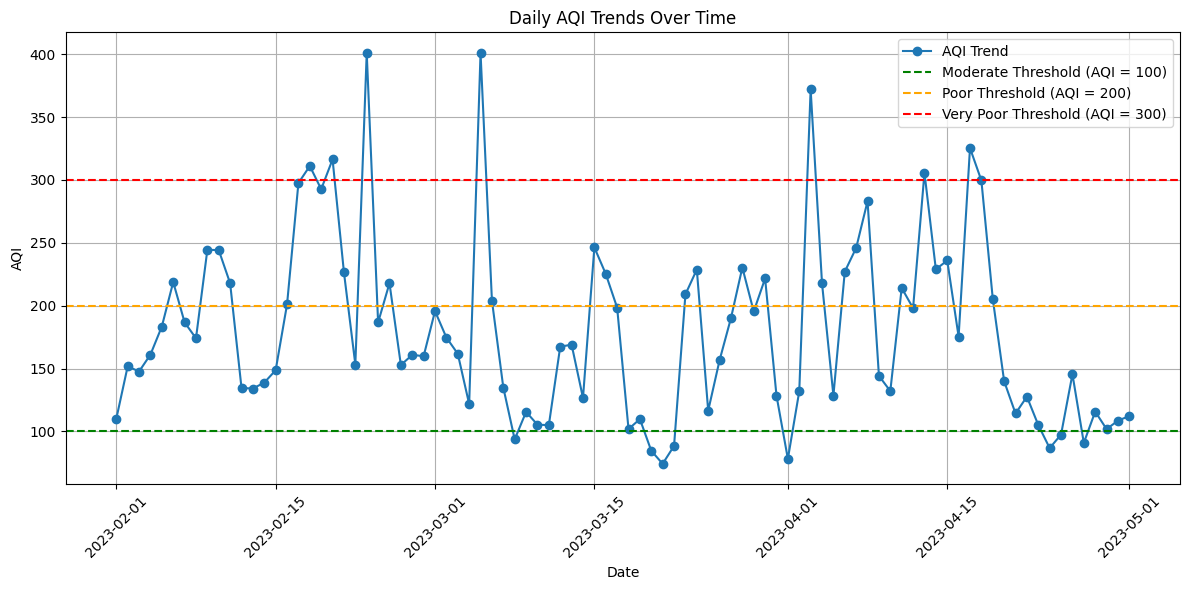

In [54]:
# Step 2: Plot AQI trends over time
plt.figure(figsize=(12, 6))
plt.plot(daily_avg['date'], daily_avg['AQI'], marker='o', linestyle='-', label='AQI Trend')
plt.axhline(100, color='green', linestyle='--', label='Moderate Threshold (AQI = 100)')
plt.axhline(200, color='orange', linestyle='--', label='Poor Threshold (AQI = 200)')
plt.axhline(300, color='red', linestyle='--', label='Very Poor Threshold (AQI = 300)')
plt.title('Daily AQI Trends Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
# Step 3: Group data by weekday and calculate average AQI for each day of the week
daily_avg['weekday'] = pd.to_datetime(daily_avg['date']).dt.day_name()
weekday_avg = daily_avg.groupby('weekday')['AQI'].mean()

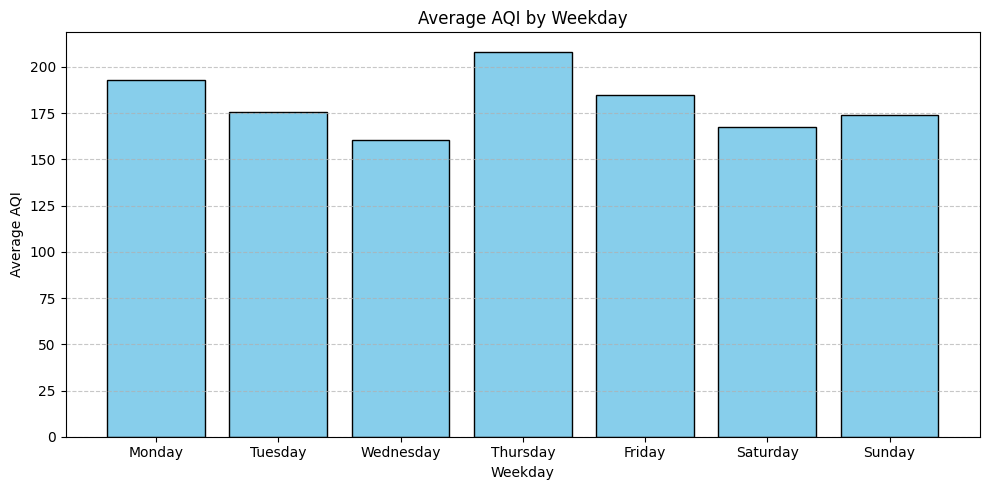

In [56]:
# Plot AQI by weekday
plt.figure(figsize=(10, 5))
weekday_avg = weekday_avg.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.bar(weekday_avg.index, weekday_avg.values, color='skyblue', edgecolor='black')
plt.title('Average AQI by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average AQI')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 2.2 Anomaly Detection

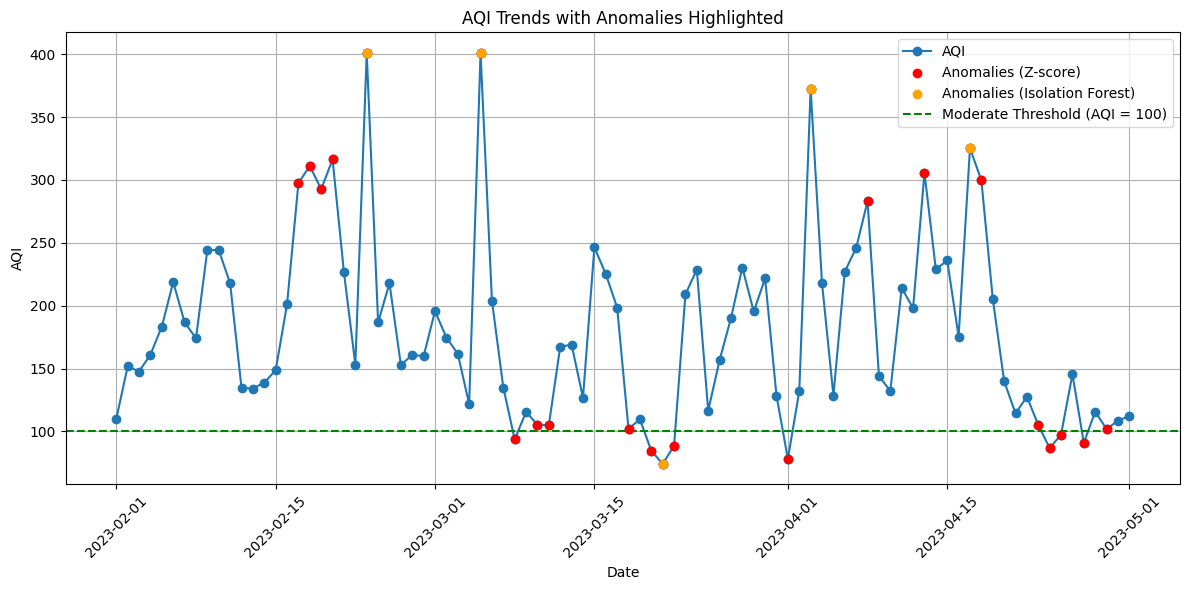

Anomalies detected using Z-scores:
                          from         PM10       PM2.5         NO        NO2  \
date                                                                            
2023-02-17 2023-02-17 11:52:30   232.437500  119.270833  11.419077  53.459444   
2023-02-18 2023-02-18 11:52:30   251.063935  134.125000  12.393631  40.030016   
2023-02-19 2023-02-19 11:52:30   190.572917  117.843750   9.197572  45.368246   
2023-02-20 2023-02-20 11:52:30   239.486071  140.927083  16.634124  43.766249   
2023-02-23 2023-02-23 11:52:30   469.239583   88.312500  20.552394  42.259072   
2023-03-05 2023-03-05 11:52:30  1827.942390  209.808816  15.229473  28.269919   
2023-03-08 2023-03-08 11:52:30    78.156250   56.281250  10.660986  50.043006   
2023-03-10 2023-03-10 11:52:30   107.645833   59.822917  13.711444  56.832720   
2023-03-11 2023-03-11 11:52:30   107.114583   56.145833   9.334041  50.088671   
2023-03-18 2023-03-18 11:52:30    93.541667   57.781250   5.761406  40.490

In [60]:
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Detect anomalies using Z-scores
daily_avg['AQI_zscore'] = (daily_avg['AQI'] - daily_avg['AQI'].mean()) / daily_avg['AQI'].std()

# Set a threshold for Z-scores to identify anomalies
zscore_threshold = 1
daily_avg['anomaly_zscore'] = daily_avg['AQI_zscore'].apply(lambda x: True if abs(x) > zscore_threshold else False)

# Step 2: Detect anomalies using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
daily_avg['anomaly_iso'] = iso_forest.fit_predict(daily_avg[['AQI']])

# Convert Isolation Forest output: -1 = anomaly, 1 = normal
daily_avg['anomaly_iso'] = daily_avg['anomaly_iso'].apply(lambda x: True if x == -1 else False)

# Step 3: Investigate anomalies
anomalies_zscore = daily_avg[daily_avg['anomaly_zscore']]
anomalies_iso = daily_avg[daily_avg['anomaly_iso']]

# Step 4: Visualization of anomalies
plt.figure(figsize=(12, 6))
plt.plot(daily_avg['date'], daily_avg['AQI'], marker='o', linestyle='-', label='AQI')
plt.scatter(anomalies_zscore['date'], anomalies_zscore['AQI'], color='red', label='Anomalies (Z-score)', zorder=5)
plt.scatter(anomalies_iso['date'], anomalies_iso['AQI'], color='orange', label='Anomalies (Isolation Forest)', zorder=5)
plt.axhline(100, color='green', linestyle='--', label='Moderate Threshold (AQI = 100)')
plt.title('AQI Trends with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Example: Examine potential meteorological factors if additional data is available
print("Anomalies detected using Z-scores:")
print(anomalies_zscore)

print("\nAnomalies detected using Isolation Forest:")
print(anomalies_iso)

### 2.3 Correlation Analysis

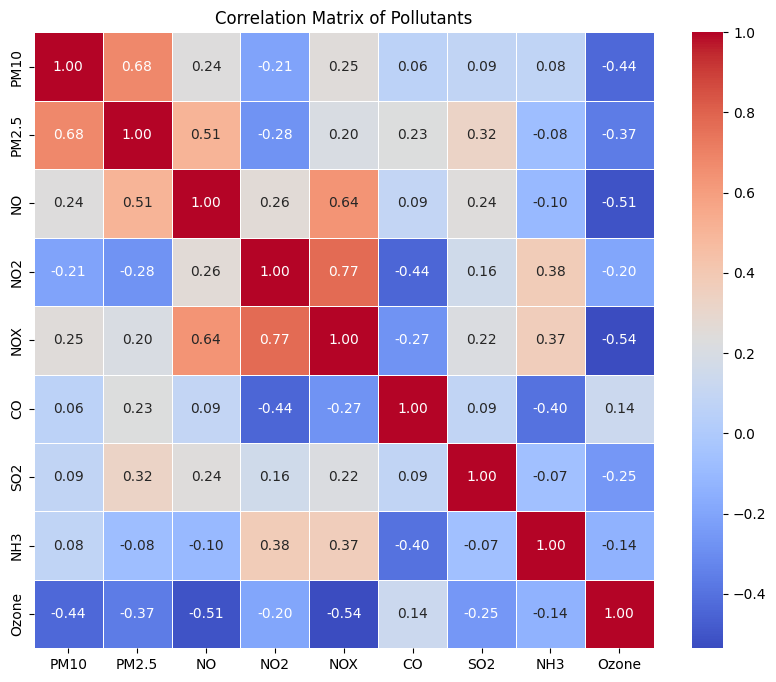

Weather data (Temperature, Humidity, WindSpeed) not available in the dataset.


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Correlation analysis between pollutants
# Select only the pollutant columns for correlation analysis
pollutant_columns = ['PM10', 'PM2.5', 'NO', 'NO2', 'NOX', 'CO', 'SO2', 'NH3', 'Ozone']
correlation_matrix = daily_avg[pollutant_columns].corr()

# Step 2: Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Pollutants')
plt.show()

# Step 3: If weather data is available, analyze correlations with AQI
# Assuming weather columns are available (e.g., 'Temperature', 'Humidity', 'WindSpeed') --- here not available
weather_columns = ['Temperature', 'Humidity', 'WindSpeed']
if all(col in daily_avg.columns for col in weather_columns):
    # Add AQI to the list for correlation
    analysis_columns = pollutant_columns + weather_columns + ['AQI']
    weather_correlation_matrix = daily_avg[analysis_columns].corr()

    # Plot the heatmap for pollutant-weather correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(weather_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Pollutants and Weather Data')
    plt.show()
else:
    print("Weather data (Temperature, Humidity, WindSpeed) not available in the dataset.")


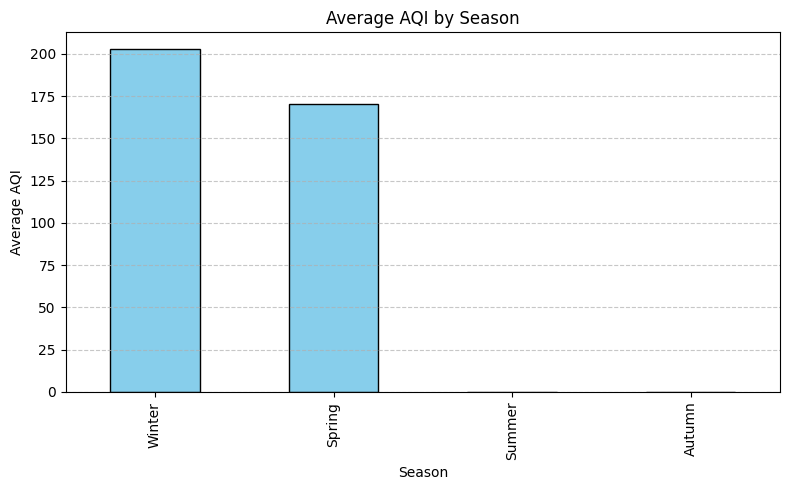

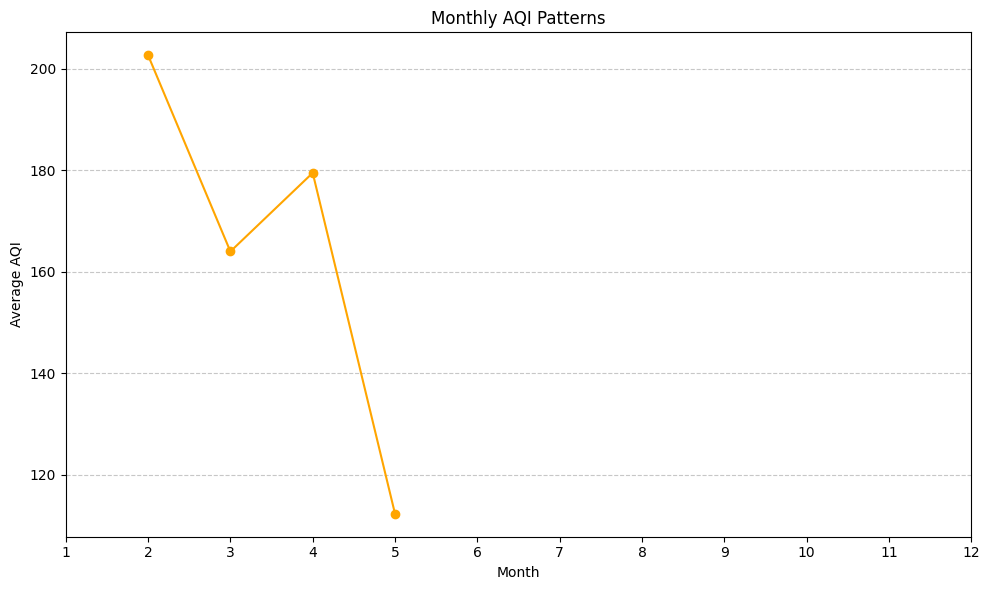

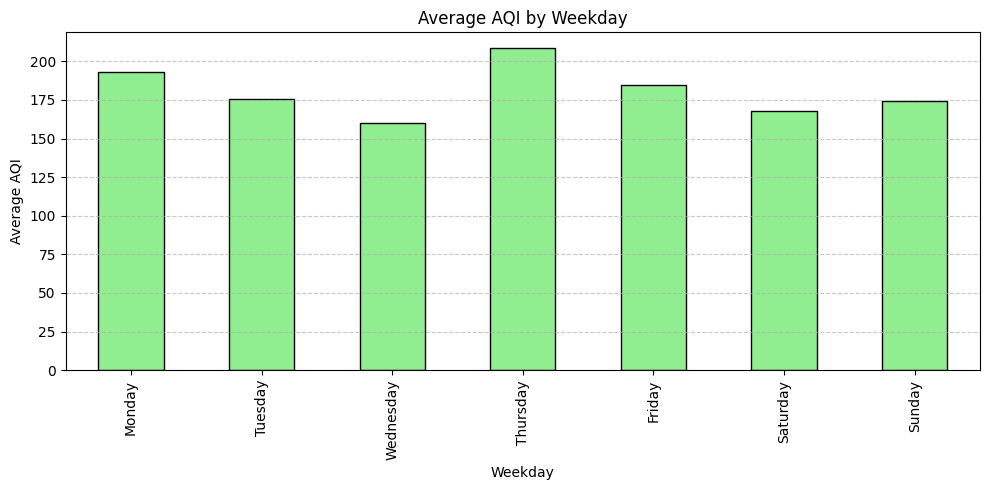

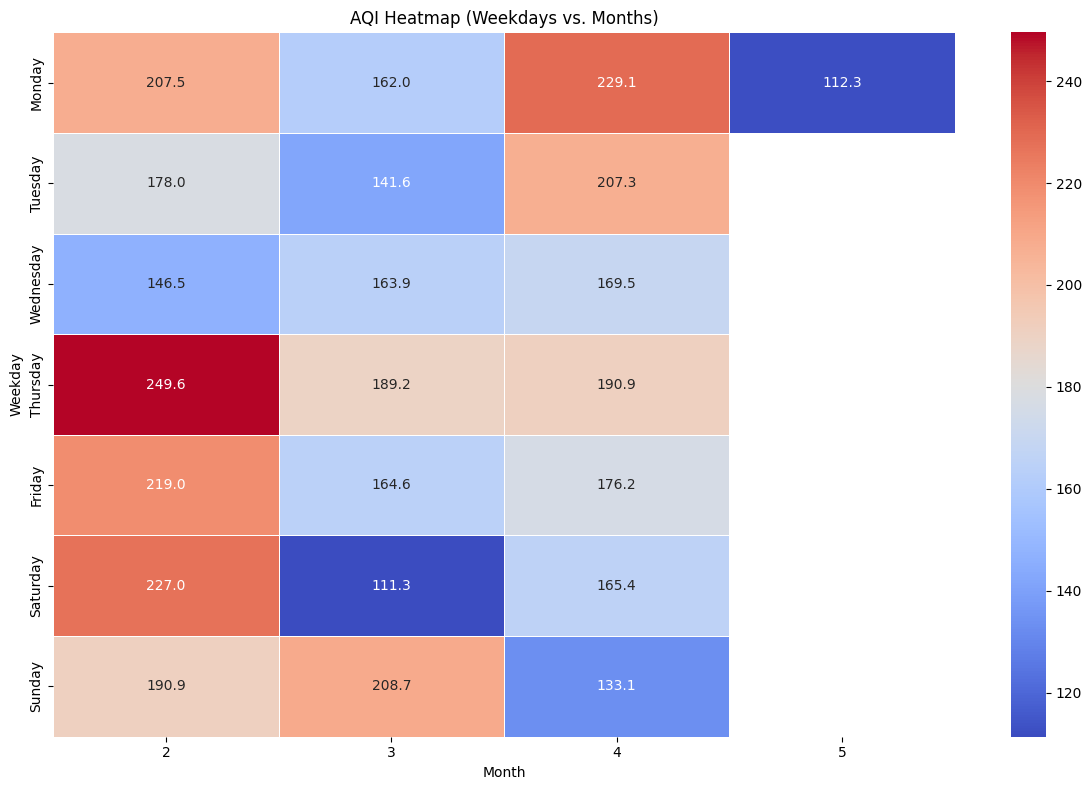

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Add seasonal, month, and weekday information to the dataset
daily_avg['month'] = pd.to_datetime(daily_avg['date']).dt.month
daily_avg['weekday'] = pd.to_datetime(daily_avg['date']).dt.day_name()

# Define seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

daily_avg['season'] = daily_avg['month'].apply(get_season)

# Step 2: Analyze AQI patterns by season
seasonal_avg = daily_avg.groupby('season')['AQI'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

# Plot seasonal AQI patterns
plt.figure(figsize=(8, 5))
seasonal_avg.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average AQI by Season')
plt.xlabel('Season')
plt.ylabel('Average AQI')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 3: Analyze AQI patterns by month
monthly_avg = daily_avg.groupby('month')['AQI'].mean()

# Plot monthly AQI patterns
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='line', marker='o', color='orange', label='Monthly AQI')
plt.title('Monthly AQI Patterns')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

# Step 4: Analyze AQI patterns by weekday
weekday_avg = daily_avg.groupby('weekday')['AQI'].mean()

# Reorder weekdays
weekday_avg = weekday_avg.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot weekday AQI patterns
plt.figure(figsize=(10, 5))
weekday_avg.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Average AQI by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average AQI')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 5: Create heatmap for AQI variations (e.g., month vs. day of the week)
heatmap_data = daily_avg.pivot_table(values='AQI', index='weekday', columns='month', aggfunc='mean')
heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5)
plt.title('AQI Heatmap (Weekdays vs. Months)')
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()


High AQI in starting months might be because of less temperature resulting in smogs

# Calculating AQI hourly not possible as we require at least 90 datapoints in an hour  which we do not have as we have reading for every 15 minutes only i.e. 4 datapoints per hour.